# Calibration

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from helper import warp, getSobelBinaryX, getSobelBinaryY, getSobelX, getSobelY,\
                    getSobelDirection, getSatBinary, combineBinary, windSlide, usePrevSlide, getLaplace, getThres
from pipeline import pipeline

%matplotlib inline

In [3]:
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x, y coordinates

for fname in images:
    #read in each image
    img = mpimg.imread(fname)
    
    # convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

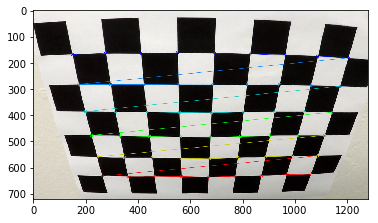

In [4]:
fname = 'camera_cal/calibration2.jpg'
img = mpimg.imread(fname)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
plt.imshow(img)

In [5]:
def calibrate(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [6]:
# Save a calibrated image for final report
import scipy.misc
fname = 'test_images/test1.jpg'
img = mpimg.imread(fname)
new_img = calibrate(img, objpoints, imgpoints)
scipy.misc.imsave('output_images/test1.jpg', new_img)
#f, axes = plt.subplots(1, 2, figsize=(20,10))
#axes[0].imshow(img)
#axes[1].imshow(new_img)

## Thresholding Functions

In [7]:
def eq_Hist(img): # Histogram normalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img

'\nf, axes = plt.subplots(3, 2, figsize=(25,15))\naxes[0,0].set_title(\'Gray\')\naxes[0,0].imshow(gray, cmap=\'gray\')\n\naxes[0,1].set_title(\'S Channel\')\naxes[0,1].imshow(s_channel, cmap=\'gray\')\n\naxes[1,0].set_title(\'S Sobel\')\naxes[1,0].imshow(s_binary, cmap=\'gray\')\n\nsbinary_warped = np.zeros_like(sxbinary)\nsbinary_warped[(sxbinary == 1) | (s_binary == 1)] = 1\nsbinary_warped, minv = warp(s_binary)\n\naxes[1,1].set_title(\'S Sobel Warped\')\naxes[1,1].imshow(sbinary_warped, cmap=\'gray\')\n\naxes[2,0].set_title(\'Gray Sobel\')\naxes[2,0].imshow(sxbinary, cmap=\'gray\')\n\ngray_binary_warped = np.zeros_like(sxbinary)\ngray_binary_warped[(sxbinary == 1) | (s_binary == 1)] = 1\ngray_binary_warped, minv = warp(gray_binary_warped)\n\naxes[2,1].set_title(\'Gray Sobel Warp\')\ngray_binary_warped = cv2.morphologyEx(gray_binary_warped, cv2.MORPH_OPEN, (9,9))\naxes[2,1].imshow(gray_binary_warped, cmap=\'gray\')\n\nf.suptitle("test5", fontsize=24)\nbinary_warped = gray_binary_warp

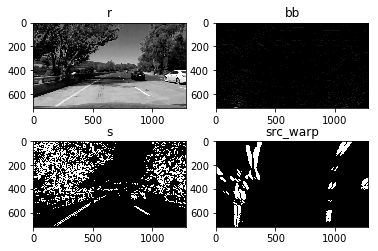

In [8]:
fname = 'test_images/test5.jpg'
img = mpimg.imread(fname)
img = calibrate(img, objpoints, imgpoints)
img_size = (img.shape[1], img.shape[0])
kernel = np.ones((3,3),np.uint8)
# Grayscale image
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Convert to HLS color space and separate the S channel
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
l_channel = hls[:,:,1]
h_channel = hls[:,:,0]

r_channel = img[:,:,0]
g_channel = img[:,:,1]
b_channel = img[:,:,2]

lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
ll_channel,a_channel,bb_channel = cv2.split(lab_image)
bb_channel, minv = warp(bb_channel)
bb_channel = cv2.morphologyEx(bb_channel, cv2.MORPH_TOPHAT, (5,5))
#bb_channel = getThres(bb_channel, thresh_min = 150)
#r_channel = getThres(r_channel, thresh_min = 180)
#r_channel = getSobelBinaryX(r_channel, sobel_kernel = 15, thresh_min = 190, thresh_max=255)
#r_channel = cv2.morphologyEx(r_channel, cv2.MORPH_OPEN, (3,3))
src = s_channel* 0.6 + gray * 0.4
src = np.array( src).astype ('uint8')
#src = np.array( src / 255.).astype ('float32') - 0.5
blurf = np.zeros((1, 5))
blurf.fill (1)
src = cv2.filter2D(src, cv2.CV_32F, blurf)
f = np.zeros((1, 30))
f.fill (1)
l = cv2.morphologyEx(src, cv2.MORPH_OPEN, f)
src = src - l
#src = getThres(src, thresh_min = 80)
src = getSobelBinaryX(src, sobel_kernel = 15, thresh_min = 190, thresh_max=255)
#cv2.morphologyEx(src, cv2.MORPH_CLOSE, blurf)
src_warp, minv = warp(src)
fig, ax = plt.subplots(2, 2)
ax[0,0].set_title('r')
ax[0,0].imshow(r_channel, cmap='gray')
ax[1,0].set_title('s')
ax[1,0].imshow(src, cmap='gray')
ax[0,1].set_title('bb')
ax[0,1].imshow(bb_channel, cmap='gray')
ax[1,1].set_title('src_warp')
ax[1,1].imshow(src_warp, cmap='gray')
binary_warped = src_warp
# Grayscale image
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Threshold x gradient
sxbinary = getSobelBinaryX(gray, sobel_kernel = 15, thresh_min = 170, thresh_max=255)

# Threshold y gradient
sybinary = getSobelBinaryY(gray, sobel_kernel = 15, thresh_min = 245, thresh_max=255)

# Threshold direction gradient
dirbinary = getSobelDirection(gray, sobel_kernel = 3, thresh_min = np.pi/2-0.3, thresh_max=np.pi/2-0.2)

# Threshold color channel
s_binary = getSatBinary(s_channel, thresh_min = 140, thresh_max=255)
s_binary = getSobelBinaryX(s_channel, sobel_kernel = 15, thresh_min = 235, thresh_max=255)

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = warp(np.dstack(( np.zeros_like(sxbinary), s_binary, sxbinary)) * 255)

# Do canny edge detection
canny_img = getLaplace(s_channel, thresh_min = 200, thresh_max=255);
#gray_binary_warped = cv2.morphologyEx(gray_binary_warped, cv2.MORPH_OPEN, kernel)
# Plotting thresholded images
'''
f, axes = plt.subplots(3, 2, figsize=(25,15))
axes[0,0].set_title('Gray')
axes[0,0].imshow(gray, cmap='gray')

axes[0,1].set_title('S Channel')
axes[0,1].imshow(s_channel, cmap='gray')

axes[1,0].set_title('S Sobel')
axes[1,0].imshow(s_binary, cmap='gray')

sbinary_warped = np.zeros_like(sxbinary)
sbinary_warped[(sxbinary == 1) | (s_binary == 1)] = 1
sbinary_warped, minv = warp(s_binary)

axes[1,1].set_title('S Sobel Warped')
axes[1,1].imshow(sbinary_warped, cmap='gray')

axes[2,0].set_title('Gray Sobel')
axes[2,0].imshow(sxbinary, cmap='gray')

gray_binary_warped = np.zeros_like(sxbinary)
gray_binary_warped[(sxbinary == 1) | (s_binary == 1)] = 1
gray_binary_warped, minv = warp(gray_binary_warped)

axes[2,1].set_title('Gray Sobel Warp')
gray_binary_warped = cv2.morphologyEx(gray_binary_warped, cv2.MORPH_OPEN, (9,9))
axes[2,1].imshow(gray_binary_warped, cmap='gray')

f.suptitle("test5", fontsize=24)
binary_warped = gray_binary_warped
'''

In [ ]:
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
f, ax = plt.subplots()
ax.plot(histogram)

In [ ]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [ ]:
cv2.line(out_img,(midpoint, binary_warped.shape[1]),(midpoint, 0),(255,0,0), 5)
cv2.line(out_img,(leftx_base, binary_warped.shape[1]),(leftx_base, 0),(255,0,0), 5)
cv2.line(out_img,(rightx_base, binary_warped.shape[1]),(rightx_base, 0),(255,0,0), 5)
nwindows = 9
margin = 100
win_height = np.int(binary_warped.shape[0]/nwindows)
win_y_bot = binary_warped.shape[0]
win_y_top = binary_warped.shape[0] - win_height
win_xleft_bot = leftx_base - margin
win_xleft_top = leftx_base + margin
cv2.rectangle(out_img,(win_xleft_bot,win_y_bot),(win_xleft_top,win_y_top),
        (0,255,0), 2)
f, ax = plt.subplots()
ax.imshow(out_img)

In [ ]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

In [ ]:
left_fitx, right_fitx, ploty = windSlides(binary_warped)

In [ ]:
def windSlides(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 90
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_top = binary_warped.shape[0] - (window+1)*window_height
        win_y_bot = binary_warped.shape[0] - window*window_height
        win_xleft_bot = leftx_current - margin
        win_xleft_top = leftx_current + margin
        win_xright_bot = rightx_current - margin
        win_xright_top = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_bot,win_y_bot),(win_xleft_top,win_y_top),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_bot,win_y_bot),(win_xright_top,win_y_top),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_top) & (nonzeroy < win_y_bot) & 
        (nonzerox >= win_xleft_bot) &  (nonzerox < win_xleft_top)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_top) & (nonzeroy < win_y_bot) & 
        (nonzerox >= win_xright_bot) &  (nonzerox < win_xright_top)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    fig, ax = plt.subplots()
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    return left_fitx, right_fitx, ploty

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        self.left_fit = None
        
        self.right_fit = None
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.left_curverad = None
        self.right_curverad = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

lanes = Line()

In [14]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    return pipeline(image, objpoints, imgpoints,lanes)

In [15]:
proj_video_out = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(proj_video_out, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [17:55<00:00,  1.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 21min 53s, sys: 17.1 s, total: 22min 11s
Wall time: 17min 56s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_video_out))

In [17]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        self.left_fit = None
        
        self.right_fit = None
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.left_curverad = None
        self.right_curverad = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

lanes = Line()

In [18]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    return pipeline(image, objpoints, imgpoints,lanes)

In [19]:
proj_video_out = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(proj_video_out, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [06:49<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 8min 20s, sys: 6.79 s, total: 8min 27s
Wall time: 6min 49s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_video_out))